In [92]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [93]:
CURRENT_DIR = os.path.abspath(os.path.dirname(__name__))
DATA_DIR = os.path.join(CURRENT_DIR, 'data')

TRAIN_DATA_FILE = os.path.join(DATA_DIR, 'adult.data')
TEST_DATA_FILE = os.path.join(DATA_DIR, 'adult.test')

In [94]:
from collections import OrderedDict

data_types = OrderedDict([
    ("age", "int"),
    ("workclass", "category"),
    ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"),
    ("education_num", "int"),
    ("marital_status", "category"),
    ("occupation", "category"),
    ("relationship", "category"),
    ("race", "category"),
    ("sex", "category"),
    ("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),
    ("hours_per_week", "int"),
    ("native_country", "category"),
    ("income_class", "category"),
])
target_column = "income_class"
features = list(data_types.keys())
numerical_features = [
    'age',
    'education_num',
    'hours_per_week',
    'capital_gain',
    'capital_loss',
]
features

['age',
 'workclass',
 'final_weight',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'income_class']

In [95]:
def read_dataset(path):
    return pd.read_csv(
        path,
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    )

def clean_dataset(data):
    # Test dataset has dot at the end, we remove it in order
    # to unify names between training and test datasets.
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    
    # Remove final weight column since there is no use
    # for it during the classification.
    data = data.drop('final_weight', axis=1)
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()
    
    # Binarize target variable (>50K == 1 and <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)

    return data

def deduplicate(train_data, test_data):
    train_data['is_test'] = 0
    test_data['is_test'] = 1

    data = pd.concat([train_data, test_data])
    # For some reason concatenation converts this column to object
    data['native_country'] = data.native_country.astype('category')
    data = data.drop_duplicates()
    
    train_data = data[data.is_test == 0].drop('is_test', axis=1)
    test_data = data[data.is_test == 1].drop('is_test', axis=1)
    
    return train_data, test_data

train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))

# Note that we did de-duplication per dataset, but there are duplicates
# between training and test data. With duplicates between datasets
# we will might get overconfident results.
train_data, test_data = deduplicate(train_data, test_data)
print("Percent of the positive classes in the training data: {:.2%}".format(np.mean(train_data.income_class)))

Percent of the positive classes in the training data: 24.78%


# Numerical features normalization

In [96]:
scaler = MinMaxScaler()
features_normalized = pd.DataFrame(data = features)
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])
test_data[numerical_features] = scaler.fit_transform(test_data[numerical_features])

# Categorical features to separate columns

In [97]:
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)
train_data.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,income_class,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.301370,0.800000,0.052626,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Linear Regression

In [85]:
def linear_regression_test(X_train, Y_train, X_test, Y_test):
    model = LogisticRegression(max_iter = 1000)
    model.fit(X_train,Y_train)

    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)

    print("Training accuracy = ", accuracy_score(Y_train,Y_pred_train, normalize = True))
    print("Test accuracy = ", accuracy_score(Y_test,Y_pred_test, normalize = True))

# Linear regression with only category features

In [104]:
def buildX(data):
    features = [
    ]
    dataset = pd.concat([data[features],
                        data.filter(regex=("workclass*")),
                        data.filter(regex=("education*")),
                        data.filter(regex=("sex*"))], axis = 1)
    dataset.describe()
    return dataset

X_train = buildX(train_data).values.astype(float)
Y_train = train_data[target_column].values

X_test = buildX(test_data).values.astype(float)
Y_test = test_data[target_column].values

linear_regression_test(X_train, Y_train, X_test, Y_test)

Training accuracy =  0.8158166070937586
Test accuracy =  0.8244314830591782


# Linear regression with only numerical features

In [99]:
def buildX(data):
    features = [
    'age',
    'education_num',
    'hours_per_week',
    ]
    dataset = pd.concat([data[features]], axis = 1)
    dataset.describe()
    return dataset

X_train = buildX(train_data).values.astype(float)
Y_train = train_data[target_column].values

X_test = buildX(test_data).values.astype(float)
Y_test = test_data[target_column].values

linear_regression_test(X_train, Y_train, X_test, Y_test)

Training accuracy =  0.7819287874621941
Test accuracy =  0.7872075496428338


# Full linear regression

In [88]:
def buildX(data):
    features = [
    'age',
    'education_num',
    'hours_per_week',
    ]
    dataset = pd.concat([data[features],
                        data.filter(regex=("workclass*")),
                        data.filter(regex=("education*")),
                        data.filter(regex=("sex*"))], axis = 1)
    dataset.describe()
    return dataset

X_train = buildX(train_data).values.astype(float)
Y_train = train_data[target_column].values

X_test = buildX(test_data).values.astype(float)
Y_test = test_data[target_column].values

linear_regression_test(X_train, Y_train, X_test, Y_test)

Training accuracy =  0.8191160296948035
Test accuracy =  0.8245625532472639


# Decision Tree

In [91]:
for depth in range(6,30):
    model = DecisionTreeClassifier(max_depth = depth)
    model.fit(X_train,Y_train)

    targ_names = [
        ">50K",
        "<=50K"
    ]

    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)
    print("MaxDepth=",depth)
    print("Training accuracy = ", accuracy_score(Y_train,Y_pred_train, normalize = True))
    print("Test accuracy = ", accuracy_score(Y_test,Y_pred_test, normalize = True))


MaxDepth= 6
Training accuracy =  0.8214187517184492
Test accuracy =  0.8191231404417065
MaxDepth= 7
Training accuracy =  0.826024195765741
Test accuracy =  0.819844026476178
MaxDepth= 8
Training accuracy =  0.8332760516909541
Test accuracy =  0.8276427026672784
MaxDepth= 9
Training accuracy =  0.836644212262854
Test accuracy =  0.8262664656923783
MaxDepth= 10
Training accuracy =  0.8405966455870223
Test accuracy =  0.8216134740153352
MaxDepth= 11
Training accuracy =  0.8465424800659884
Test accuracy =  0.8178124385608493
MaxDepth= 12
Training accuracy =  0.8532444322243607
Test accuracy =  0.8168294121502064
MaxDepth= 13
Training accuracy =  0.8598089084410229
Test accuracy =  0.8160429910216921
MaxDepth= 14
Training accuracy =  0.8669576574099532
Test accuracy =  0.811914280096992
MaxDepth= 15
Training accuracy =  0.8733502886994776
Test accuracy =  0.810472508028049
MaxDepth= 16
Training accuracy =  0.8809114654935386
Test accuracy =  0.804836489940363
MaxDepth= 17
Training accuracy 

Training accuracy =  0.7851594720923838
Test accuracy =  0.7894357428402909


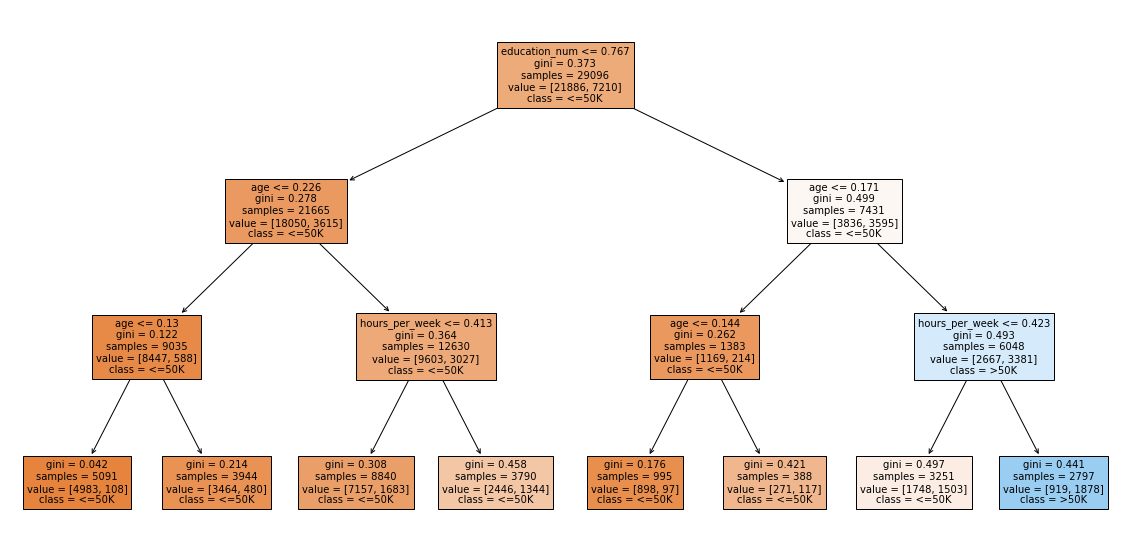

In [101]:
model = DecisionTreeClassifier(max_depth = 3)
model.fit(X_train,Y_train)

targ_names = [
    "<=50K",
    ">50K"
]

Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

print("Training accuracy = ", accuracy_score(Y_train,Y_pred_train, normalize = True))
print("Test accuracy = ", accuracy_score(Y_test,Y_pred_test, normalize = True))
fig, ax = plt.subplots(figsize=(20, 10))  
plot_tree(model, ax=ax, fontsize=10, \
          feature_names=buildX(train_data).columns, class_names=targ_names, filled=True)
plt.show()

# Conclusions

1. We have built 2 predictive models (Linear Regression and Decision Tree)

2. Linear Regression has accuracy around 0.819 on training set and 0.825 on test set, that means that algorithm is not overfitting.

3. Decision tree has best accuracy around 0.833 on training set and 0.828 on test set with deep of the tree = 8. We can see that with increasing tree height algorithm has more accuracy on training set and less accuracy on test set, that means that the algo is overfitting.

4. We can see that income correlates the most with the age, education, sex and hours_per_week and workclass. 
